# Examples of the `ridges.py` module of that `clouddrift` package.

This Jupyter notebook showcases how to use the ridge analysis functionality of `clouddrift` using two examples:
- A synthetic chirp signal
- A GDP1h tragjectory

#### Importing Libraries

In [1]:
from numpy.lib import scimath
import numpy as np
import matplotlib.pyplot as plt
from clouddrift.wavelet import (
    morse_wavelet_transform,
    morse_logspace_freq,
)
from clouddrift.sphere import (
    coriolis_frequency,
    sphere_to_plane,
)
from clouddrift.ridges import ridge_analysis
import clouddrift as cd
from clouddrift.datasets import gdp1h
import matplotlib.cm as cm
import pandas as pd

## Setting Up Colormap (Feel Free to Skip This Section)

In [2]:
# Create a discrete colormap from orange to white to green
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# Define the specific colors
orange_start = '#f47321'
white_middle = '#ffffff'
green_end =  '#005030'

# Define the number of discrete colors
n_colors = 40

def hex_to_rgb(hex_color):
    """Convert hex color to RGB values (0-1 range)"""
    hex_color = hex_color.lstrip('#')
    return tuple(int(hex_color[i:i+2], 16)/255.0 for i in (0, 2, 4))

def rgb_to_hex(rgb):
    """Convert RGB values (0-1 range) to hex color"""
    return '#{:02x}{:02x}{:02x}'.format(int(rgb[0]*255), int(rgb[1]*255), int(rgb[2]*255))

def interpolate_colors(color1, color2, n_steps):
    """Interpolate between two colors with n_steps"""
    rgb1 = hex_to_rgb(color1)
    rgb2 = hex_to_rgb(color2)
    
    colors = []
    for i in range(n_steps):
        # Linear interpolation
        t = i / (n_steps - 1)
        r = rgb1[0] * (1 - t) + rgb2[0] * t
        g = rgb1[1] * (1 - t) + rgb2[1] * t
        b = rgb1[2] * (1 - t) + rgb2[2] * t
        colors.append((r, g, b))
    
    return colors

def create_three_color_gradient(color1, color2, color3, n_colors):
    """Create a gradient through three colors"""
    # Split into two segments
    n_segment = n_colors // 2
    
    # First segment: color1 to color2
    first_segment = interpolate_colors(color1, color2, n_segment + 1)
    
    # Second segment: color2 to color3 (skip first color to avoid duplication)
    second_segment = interpolate_colors(color2, color3, n_colors - n_segment + 1)[1:]
    
    return first_segment + second_segment

# Generate orange to white to green colors
orange_white_green_colors = create_three_color_gradient(green_end, white_middle, orange_start, n_colors)
discrete_orange_white_green = ListedColormap(orange_white_green_colors)

## The Synthetic Chirp Signal

#### Creating the Chirp Signal

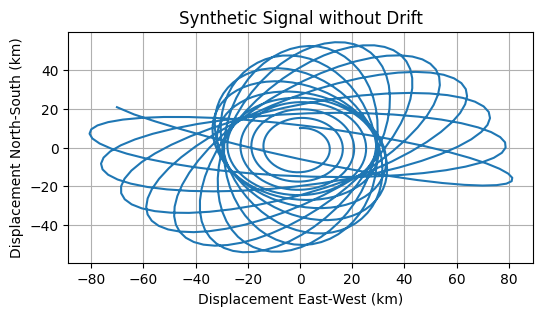

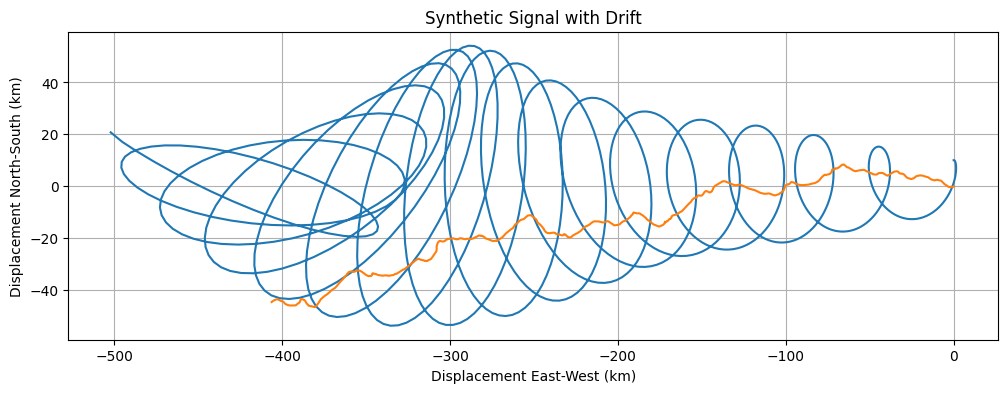

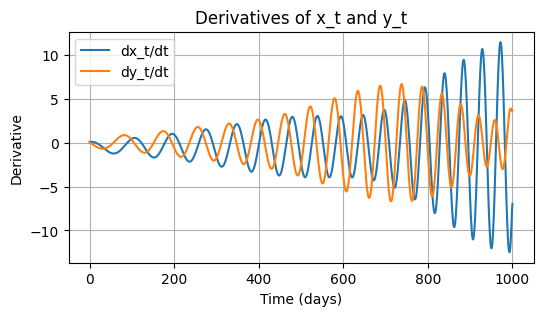

In [3]:
def synth_signal(t, tau, omega, k):
    '''
    Generates a synthetic signal based on the given parameters.
    The signal is defined in the complex plane and is then separated into
    its real and imaginary components.
    '''

    # Makes a piecewise function where for t < tau/4, the signal is -1 
    # and for t >= tau/4, the signal is defined with complex-safe sqrt
    xi_t = np.piecewise(
        t,
        [t < tau/4.0, t >= tau/4.0],
        [
            -1.0,
            lambda x: -scimath.sqrt(1.0 - (1/3.0*(4.0 * x / tau - 1.0)) ** 2.0),
        ],
    )

    k_t = k * (1 + 5.0 * t / tau)

    a_t = k_t * scimath.sqrt(1.0 + scimath.sqrt(1.0 - xi_t**2.0))
    b_t = k_t * scimath.sqrt(1.0 - scimath.sqrt(1.0 - xi_t**2.0))

    phi_t = omega * t * (1.0 + t / tau)
    theta_t = np.pi / 2.0 - omega * t / 10.0

    z_t = np.exp(1j * theta_t) * (a_t * np.cos(phi_t) - 1j * b_t * np.sin(phi_t))

    x_t = z_t.real
    y_t = z_t.imag
    return x_t, y_t

def add_drift(x_t, y_t, t):
    '''
    Adds a westward drift and a stochastic component to the y_t component.

    Parameters
    ----------
    x_t : np.ndarray
        The x_t component of the synthetic signal.
    y_t : np.ndarray
        The y_t component of the synthetic signal.
    t : np.ndarray
        The time vector in days.

    Returns
    -------
    x_t_drifted : np.ndarray
        The drifted x_t component.
    y_t_drifted : np.ndarray
        The drifted y_t component.
    westward_drift : np.ndarray
        The westward drift component.
    stochastic_displacement : np.ndarray
        The stochastic displacement component.
    '''

    # 1. Uniform Westward Drift
    westward_drift_speed = -0.5 / 100 / 1000  # cm/s to km/s, westward is negative in y direction
    westward_drift = westward_drift_speed * t * 24 * 3600  # km/s * seconds in a day = meters

    # 2. Add all components to x_t and y_t
    x_t_drifted = x_t + westward_drift
    y_t_drifted = y_t

    return x_t_drifted, y_t_drifted, westward_drift


# Create a time array for 1000 days
t = np.linspace(0, 1000, 1000)

# Generate a synthetic signal with a chirp component
tau = 1000.0
omega = 0.05
k = 10.0

x_t, y_t = synth_signal(t, tau, omega, k)

# Add drift to the synthetic signal
x_t_drifted, y_t_drifted, westward_drift = add_drift(x_t, y_t, t)

# Copy in the matern noise from the following path with columns (t, noise_real, noise_imaginary):
path = "/vol/clouddrift/matern_displacement.txt"

# Load the matern noise data
matern_data = np.loadtxt(path, delimiter=",", skiprows=1)

# Extract the time and noise components
matern_t = matern_data[:, 0]
matern_noise_real = matern_data[:, 1]
matern_noise_imaginary = matern_data[:, 2]


# Add real component of matern noise to x_t_drifted
x_t_drifted_wNoise = x_t_drifted #+ matern_noise_real

# Add imaginary component of matern noise to y_t_drifted
y_t_drifted_wNoise = y_t_drifted #+ matern_noise_imaginary

# Plot the synthetic signal without drift
plt.figure(figsize=(6, 3))
plt.plot(x_t, y_t, label="Synthetic Signal")
plt.xlabel("Displacement East-West (km)")
plt.ylabel("Displacement North-South (km)")
plt.title("Synthetic Signal without Drift")
plt.grid(True)
plt.show()

# Plot the synthetic signal with the real component as the x-axis and the imaginary component as the y-axis
plt.figure(figsize=(12, 4))
plt.plot(x_t_drifted_wNoise, y_t_drifted_wNoise, label="Synthetic Signal")
plt.plot(westward_drift + matern_noise_real, matern_noise_imaginary, label="Just Noise & Drift")
plt.xlabel("Displacement East-West (km)")
plt.ylabel("Displacement North-South (km)")
plt.title("Synthetic Signal with Drift")
plt.grid(True)
plt.show()

# Plot the derivatives of x_t and y_t
plt.figure(figsize=(6, 3))
plt.plot(t, np.gradient(x_t_drifted_wNoise, t[1] - t[0]), label="dx_t/dt")
plt.plot(t, np.gradient(y_t_drifted_wNoise, t[1] - t[0]), label="dy_t/dt")
plt.xlabel("Time (days)")
plt.ylabel("Derivative")
plt.title("Derivatives of x_t and y_t")
plt.legend()
plt.grid(True)
plt.show()

#### Wavelet Analysis: Creating Morse Wavelets from the Chirp Signal

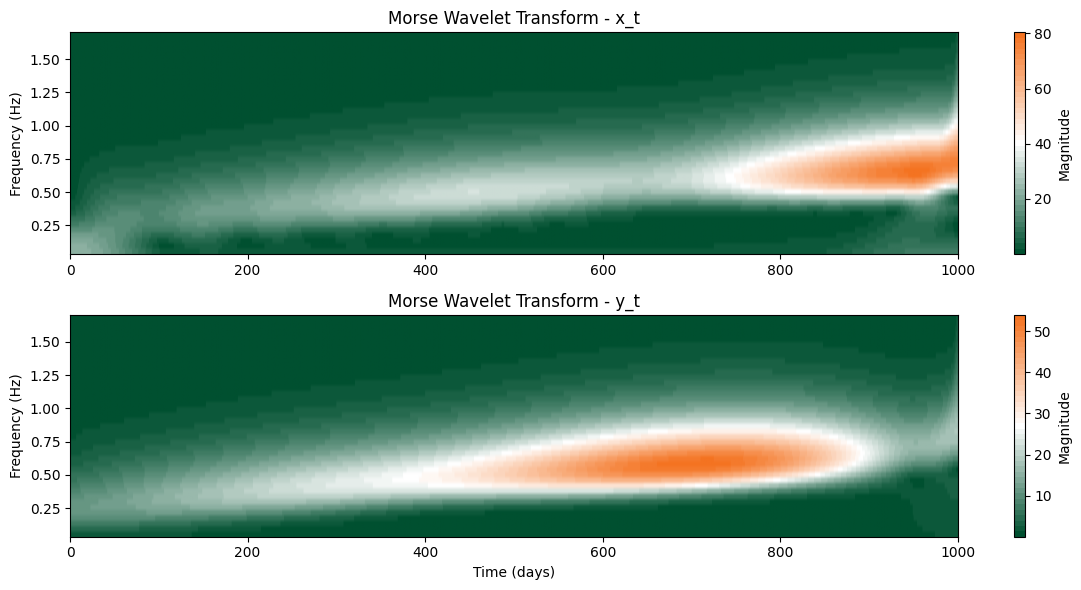

In [4]:
# Define Morse wavelet parameters
gamma = 3  # Controls time-frequency resolution trade-off
beta = 2   # Controls shape/symmetry of the wavelet

# Generate logarithmically spaced frequencies for analysis
freqs = morse_logspace_freq(gamma, beta, len(t), density=4)

# Convert from frequencies to periods for plotting
periods = 2.0*np.pi / freqs

# Apply the Morse wavelet transform
wavelet_x = morse_wavelet_transform(x_t_drifted_wNoise, gamma, beta, freqs, boundary="mirror")
wavelet_y = morse_wavelet_transform(y_t_drifted_wNoise, gamma, beta, freqs, boundary="mirror")

# Plot the wavelet transform results
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.imshow(np.abs(wavelet_x), aspect='auto', extent=[t[0], t[-1], freqs[-1], freqs[0]], cmap=discrete_orange_white_green)
plt.title("Morse Wavelet Transform - x_t")
plt.ylabel("Frequency (Hz)")
plt.colorbar(label='Magnitude')
plt.subplot(2, 1, 2)
plt.imshow(np.abs(wavelet_y), aspect='auto', extent=[t[0], t[-1], freqs[-1], freqs[0]], cmap=discrete_orange_white_green)
plt.title("Morse Wavelet Transform - y_t")
plt.xlabel("Time (days)")
plt.ylabel("Frequency (Hz)")
plt.colorbar(label='Magnitude')
plt.tight_layout()
plt.show()

#### Ridge Analysis: Finding the Ridges of the Chirp Signal Wavelet Transform using the `ridges` Module

Minimum length for groups: 0.00 periods
[1, 2, 3]
Plus transform groups: 3 total, 3 filtered
Minus transform groups: 4 total, 4 filtered


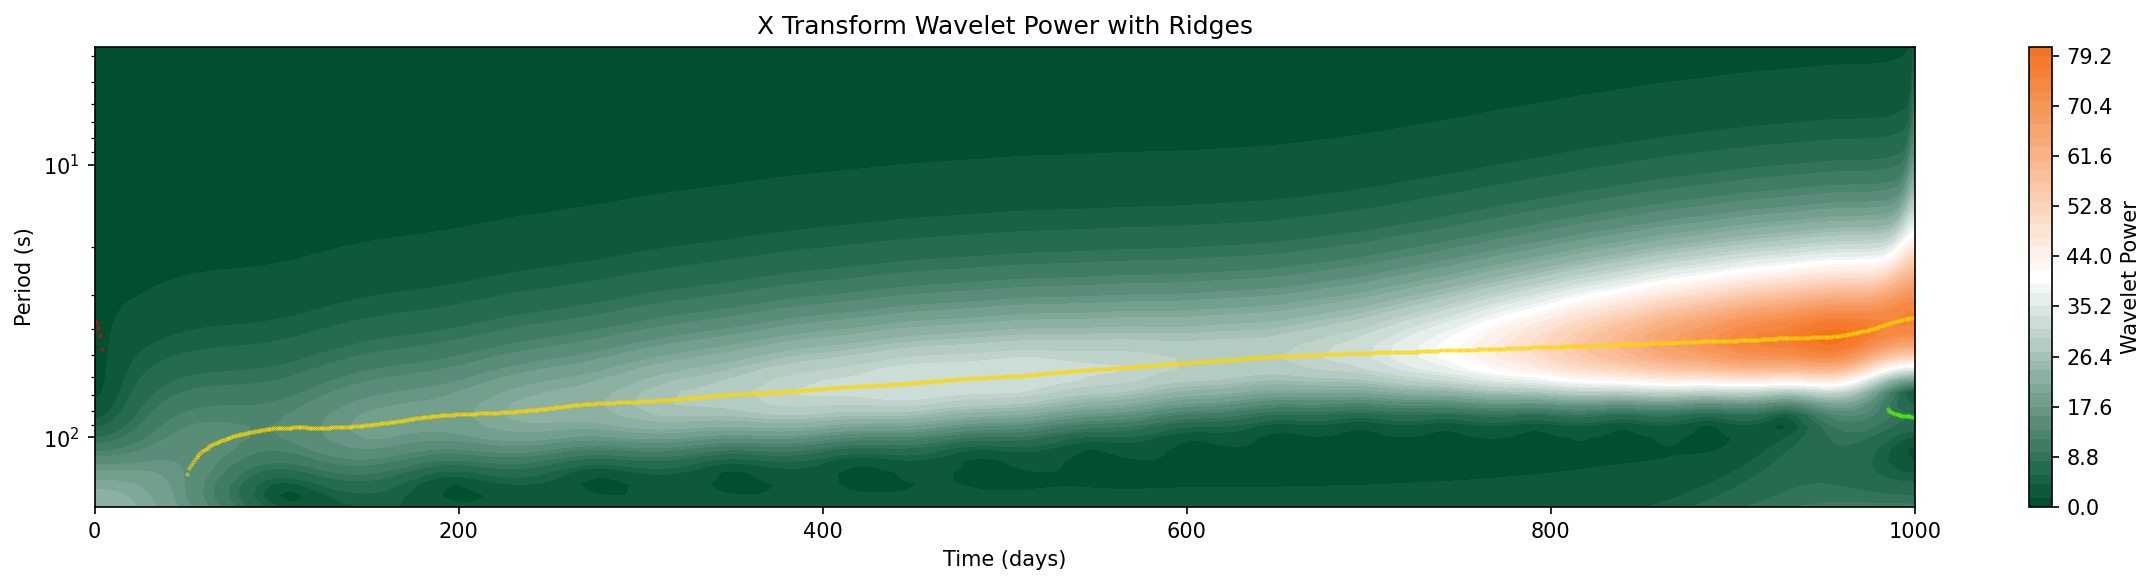

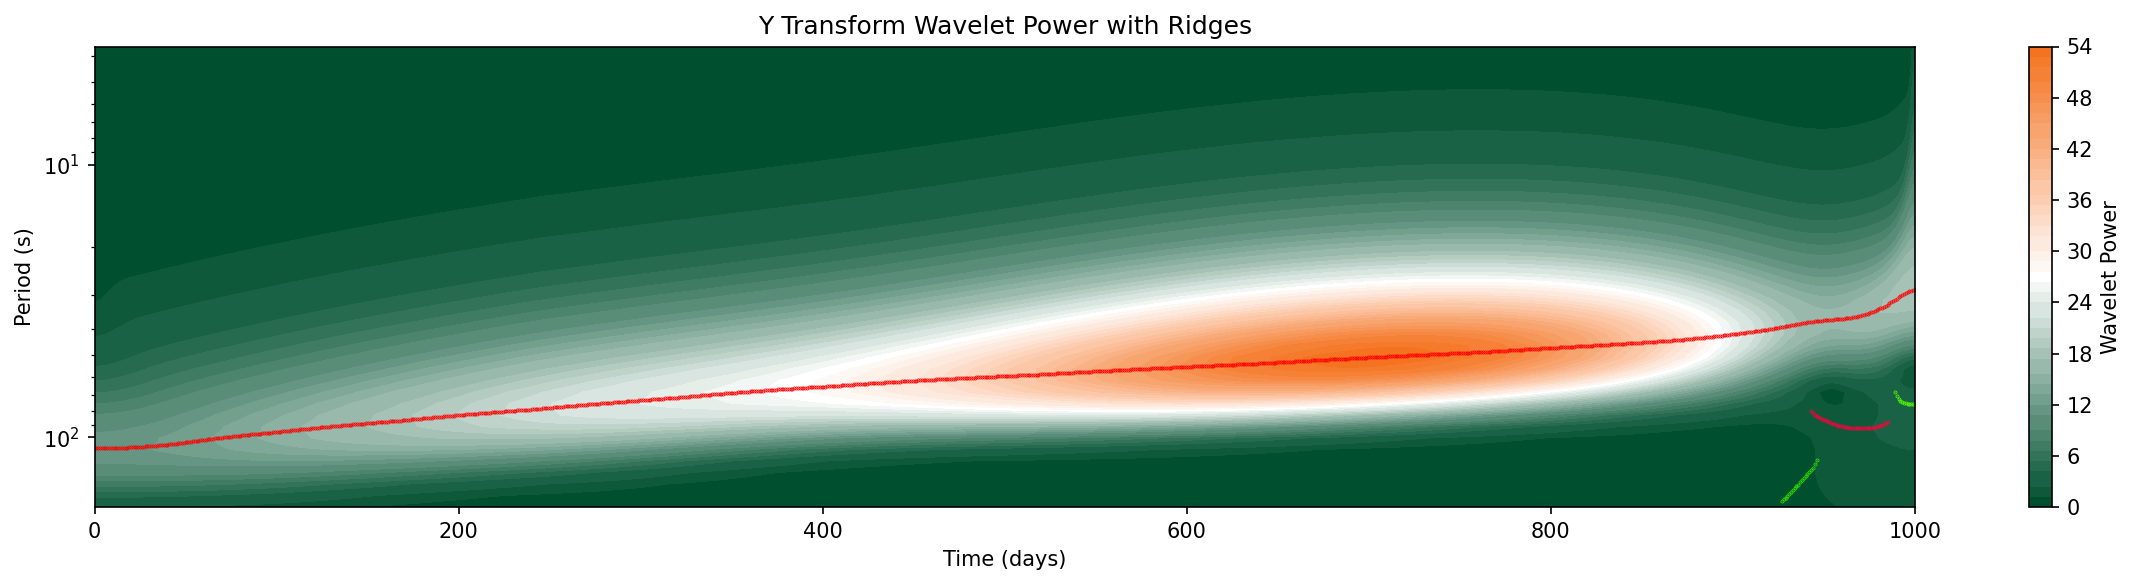

In [5]:
def wavelet_contourf(ax, time, frequencies, wavelet_coefficients, power=1, **contourf_args):
    time = np.asarray(time)
    frequencies = np.asarray(frequencies)
    wavelet_coefficients = np.asarray(wavelet_coefficients)
    if time.ndim != 1:
        raise ValueError('Expected 1d array for time')
    if frequencies.ndim != 1:
        raise ValueError('Expected 1d array for frequencies')
    if wavelet_coefficients.ndim != 2:
        raise ValueError('Expected 2d array for wavelet_coefficients')
    if wavelet_coefficients.shape != (len(frequencies), len(time)):
        raise ValueError('Expected wavelet_coefficients to have shape ({}, {}). Actual shape: {}'.format(
            len(frequencies), len(time), wavelet_coefficients.shape))
    if not np.isrealobj(wavelet_coefficients) or power != 1:
        wavelet_coefficients = np.abs(wavelet_coefficients)
    if power != 1:
        wavelet_coefficients = np.power(wavelet_coefficients, power)
    time, frequencies = np.meshgrid(time, frequencies)
    return ax.contourf(time, frequencies, wavelet_coefficients, **contourf_args)

def get_group_data(group_data_dict, group_id, data_index=1):
    """
    Extract data for a specific group from the dictionary format returned by ridge_analysis.
    
    Parameters:
    -----------
    group_data_dict : dict
        Dictionary of group data where keys are group IDs
    group_id : int
        Group ID to retrieve
    data_index : int, optional
        Index of the data to retrieve (0=ridge_quantity, 1=frequency, 2=inst_frequency, 3=inst_frequency_derivative)
    
    Returns:
    --------
    tuple: (freq_indices, time_indices, values)
    """
    if group_id not in group_data_dict:
        return np.array([]), np.array([]), np.array([])
        
    group_data = group_data_dict[group_id]
    freq_indices, time_indices = group_data['indices']
    values = group_data['values'][data_index]
    return freq_indices, time_indices, values

ridges_x = ridge_analysis(
    wavelet_x,
    freqs=freqs,
    t=t,
    ridge_type="amplitude",
    amplitude_threshold=0.1,
    min_group_size=5,
    max_gap=2
)

ridge_points_x = ridges_x['ridge_points']
ridge_quantity_x = ridges_x['ridge_quantity']
num_groups_x = ridges_x['num_groups']
group_lengths_x = ridges_x['group_lengths']
group_data_x = ridges_x['group_data']
ridge_data_x = ridges_x['ridge_data']
inst_frequency_x = ridges_x['inst_frequency']

ridges_y = ridge_analysis(
    wavelet_y,
    freqs=freqs,
    t=t,
    ridge_type="amplitude",
    amplitude_threshold=0.1,
    min_group_size=5,
    max_gap=5
)

ridge_points_y = ridges_y['ridge_points']
ridge_quantity_y = ridges_y['ridge_quantity']
num_groups_y = ridges_y['num_groups']
group_lengths_y = ridges_y['group_lengths']
group_data_y = ridges_y['group_data']
ridge_data_y = ridges_y['ridge_data']
inst_frequency_y = ridges_y['inst_frequency']

# Filter out ridges with length less than the minimum length
min_length = 0.00 * (2.0 * np.sqrt(beta * gamma) / np.pi)
print(f"Minimum length for groups: {min_length:.2f} periods")

# Filter out groups with length less than min_length
filtered_group_ids_x = [i+1 for i, length in enumerate(group_lengths_x) if length >= min_length]
filtered_group_ids_y = [i+1 for i, length in enumerate(group_lengths_y) if length >= min_length]

print(filtered_group_ids_x)

# Print statistics
print(f"Plus transform groups: {num_groups_x} total, {len(filtered_group_ids_x)} filtered")
print(f"Minus transform groups: {num_groups_y} total, {len(filtered_group_ids_y)} filtered")

# Create a new figure with both wavelet transforms
plt.figure(figsize=(16, 4), dpi=150)
colors_x = cm.prism(np.linspace(0, 1, num_groups_x))

# Plot "plus" wavelet power as background
cax_plus = wavelet_contourf(
    plt.gca(), t, periods, np.abs(wavelet_x), levels=100, cmap=discrete_orange_white_green
)

# Make ids for every group if filtered_group_ids_x is empty
if len(filtered_group_ids_x) == 0:
    filtered_group_ids_x = list(range(1, num_groups_x + 1))

for group_id in filtered_group_ids_x:
    
    # Use the new dictionary-based function
    freq_indices, time_indices, freq_values = get_group_data(
        group_data_x, group_id, data_index=0
    )
    
    # Skip if empty
    if len(freq_indices) == 0:
        continue
    
    # Get color
    color_idx = (group_id - 1) % len(colors_x)
    color = colors_x[color_idx]
        
    # Calculate interpolated period values
    interp_period_values = 2.0 * np.pi / freq_values

    # Plot interpolated ridge points
    plt.scatter(t[time_indices], interp_period_values, 
                color=color, s=0.5, marker='.', linewidth=1.5)

# Set plot properties
plt.yscale('log')
plt.gca().invert_yaxis()
plt.title("X Transform Wavelet Power with Ridges")
plt.xlabel("Time (days)")
plt.ylabel("Period (s)")
plt.colorbar(cax_plus, label='Wavelet Power')
plt.tight_layout()
plt.show()

# Create a new figure with both wavelet transforms
plt.figure(figsize=(16, 4), dpi=150)
colors_y = cm.prism(np.linspace(0, 1, num_groups_y))

# Plot "y" wavelet power as background
cax_y = wavelet_contourf(
    plt.gca(), t, periods, np.abs(wavelet_y), levels=100, cmap=discrete_orange_white_green
)

# Make ids for every group if filtered_group_ids_y is empty
if len(filtered_group_ids_y) == 0:
    filtered_group_ids_y = list(range(1, num_groups_y + 1))

for group_id in filtered_group_ids_y:
    # Use the new dictionary-based function
    freq_indices, time_indices, freq_values = get_group_data(
        group_data_y, group_id, data_index=0
    )
    
    # Skip if empty
    if len(freq_indices) == 0:
        continue
    
    # Get color
    color_idx = (group_id - 1) % len(colors_y)
    color = colors_y[color_idx]
        
    # Calculate interpolated period values
    interp_period_values = 2.0 * np.pi / freq_values

    # Plot interpolated ridge points
    plt.scatter(t[time_indices], interp_period_values, 
                color=color, s=0.5, marker='.', linewidth=1.5)
    
# Set plot properties
plt.yscale('log')
plt.gca().invert_yaxis()
plt.title("Y Transform Wavelet Power with Ridges")
plt.xlabel("Time (days)")
plt.ylabel("Period (s)")
plt.colorbar(cax_y, label='Wavelet Power')
plt.tight_layout()
plt.show()


## The GDP1h Drifter 44000

#### Use `clouddrift` to Load the GDP1h Drifter 44000

drifter index for `id` 44000 is 1757


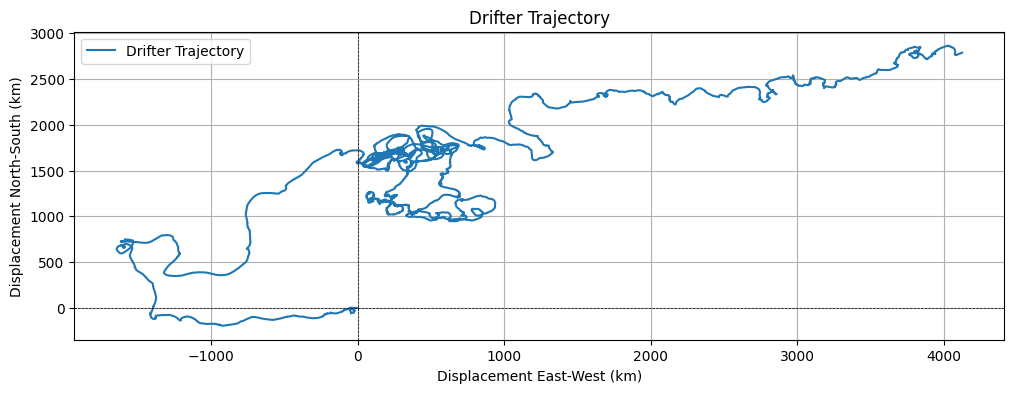

In [6]:
# Get a single drifter from the gdp1h dataset
# Load the drifter data
ds = gdp1h()

traj_idx = cd.ragged.rowsize_to_index(ds["rowsize"])

n = 44000
j = int(np.where(ds["id"]==n)[0][0])
print('drifter index for `id` '+str(n)+' is '+str(j))

# peak at the some SST data for this drifter
ds.sst1[slice(traj_idx[j], traj_idx[j+1])]
sli = slice(traj_idx[j], traj_idx[j+1])

lat = ds.lat[sli].values
lon = ds.lon[sli].values
lat0 = lat[0]
lon0 = lon[0]

x_t, y_t = sphere_to_plane(lon, lat, lon0, lat0)

# Convert the displacement from meters to kilometers
x_t = x_t / 1000.0  # Convert from meters to kilometers
y_t = y_t / 1000.0  # Convert from meters to kilometers

# Get time in days
t = ds.time[sli].values

# Convert from nanosecond to hours
t = t.astype(float)
t = t / 1e9 / 3600.0

t = t - t[0]

# Define Morse wavelet parameters
gamma = 3  # Controls time-frequency resolution trade-off
beta = 2   # Controls shape/symmetry of the wavelet

# Generate logarithmically spaced frequencies for analysis
freqs = morse_logspace_freq(gamma, beta, len(t), density=4)

# Calculate the coriolis frequency
coriolis_freq = coriolis_frequency(lat)

# Convert Coriolis frequency to radians per hour
coriolis_freq_rad = coriolis_freq * 3600

# Convert coriolis frequency to period
coriolis_period = 2.0*np.pi / coriolis_freq_rad

# Plot the displacement from north to south of the drifter
plt.figure(figsize=(12, 4))
plt.plot(x_t, y_t, label="Drifter Trajectory")
plt.xlabel("Displacement East-West (km)")
plt.ylabel("Displacement North-South (km)")
plt.title("Drifter Trajectory")
plt.grid(True)
plt.axhline(0, color='k', linestyle='--', linewidth=0.5)
plt.axvline(0, color='k', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()


#### Wavelet Analysis: Creating Morse Wavelets from GDP1h Drifter 44000

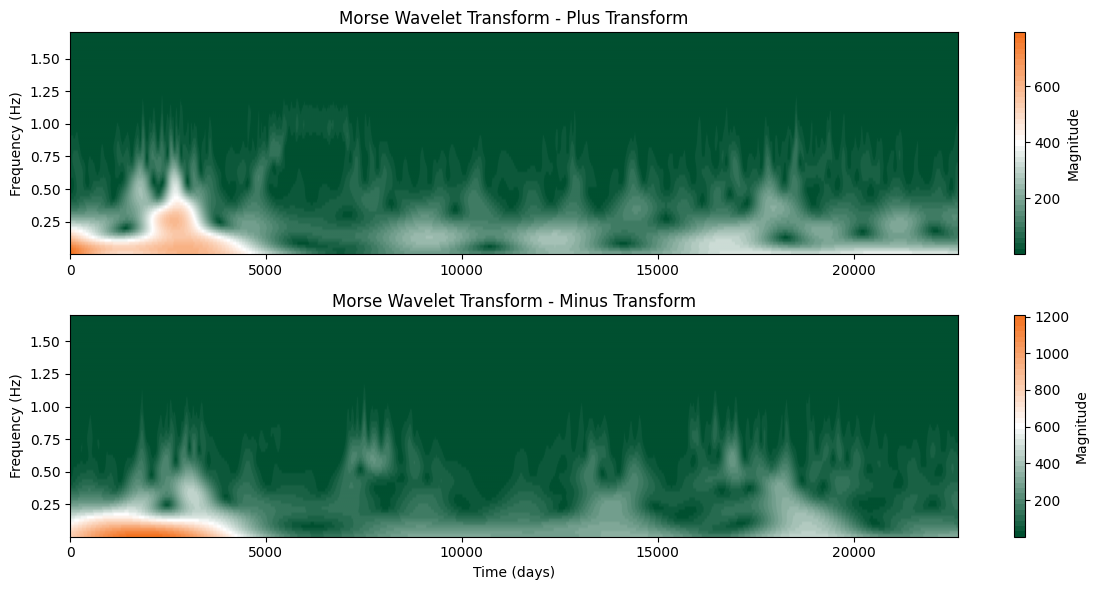

In [7]:
# Apply the Morse wavelet transform
wavelet_plus = morse_wavelet_transform(x_t + 1j*y_t, gamma, beta, freqs, boundary="mirror")
wavelet_minus = morse_wavelet_transform(x_t - 1j*y_t, gamma, beta, freqs, boundary="mirror")

power_minus = np.abs(wavelet_minus)
power_plus =np.abs(wavelet_plus)

# Convert from frequencies to periods for plotting
periods = 2.0*np.pi / freqs

# Plot the wavelet transform results
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.imshow(np.abs(wavelet_plus), aspect='auto', extent=[t[0], t[-1], freqs[-1], freqs[0]], cmap=discrete_orange_white_green)
plt.title("Morse Wavelet Transform - Plus Transform")
plt.ylabel("Frequency (Hz)")
plt.colorbar(label='Magnitude')
plt.subplot(2, 1, 2)    
plt.imshow(np.abs(wavelet_minus), aspect='auto', extent=[t[0], t[-1], freqs[-1], freqs[0]], cmap=discrete_orange_white_green)
plt.title("Morse Wavelet Transform - Minus Transform")
plt.xlabel("Time (days)")
plt.ylabel("Frequency (Hz)")
plt.colorbar(label='Magnitude')
plt.tight_layout()
plt.show()

#### Ridge Analysis: Finding the Ridges of the GDP1h Drifter 44000 Wavelet Transform using the `ridges` Module

Minimum length for groups: 3.43 periods
Plus transform groups: 311 total, 12 filtered
Minus transform groups: 520 total, 47 filtered


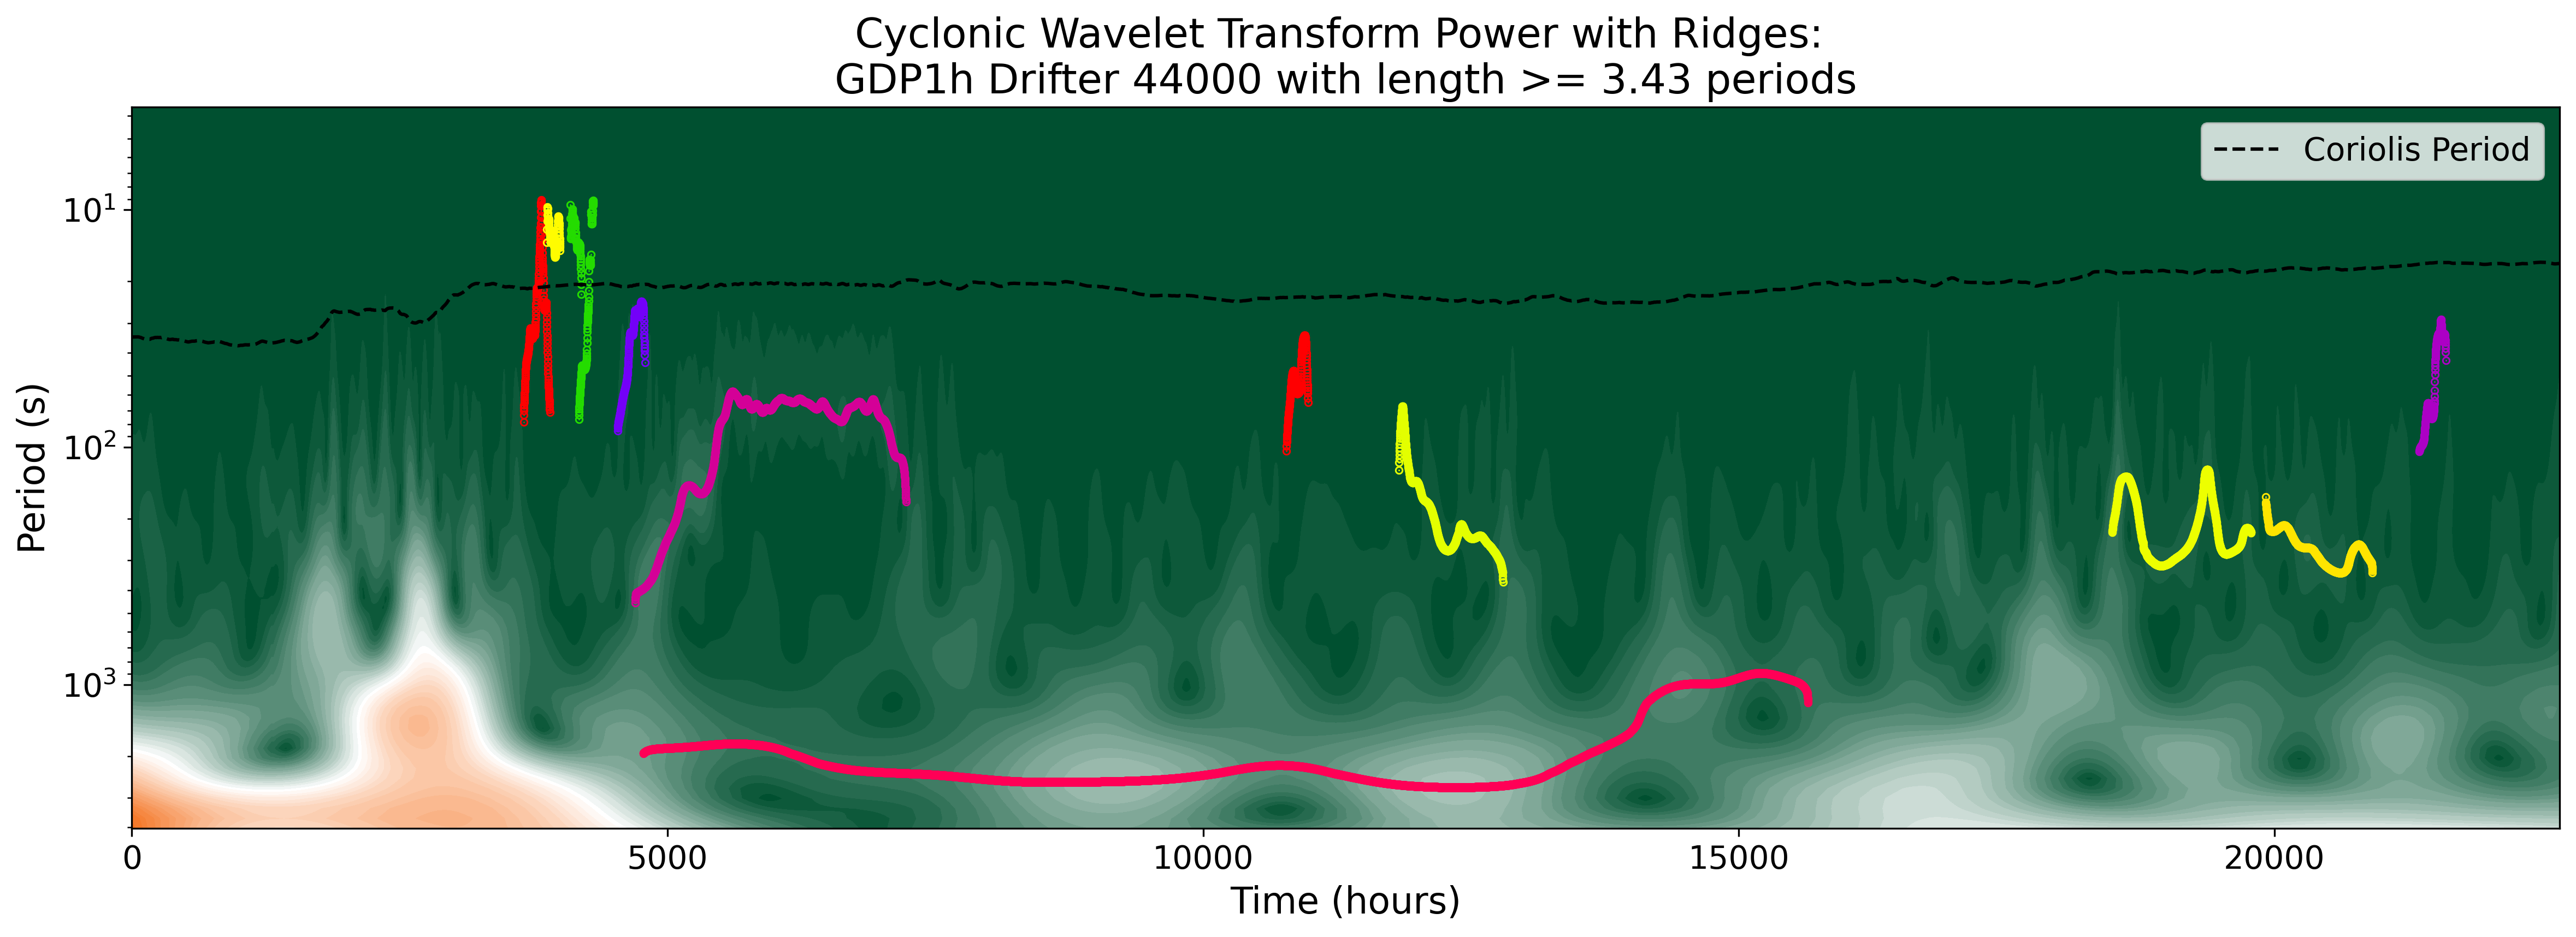

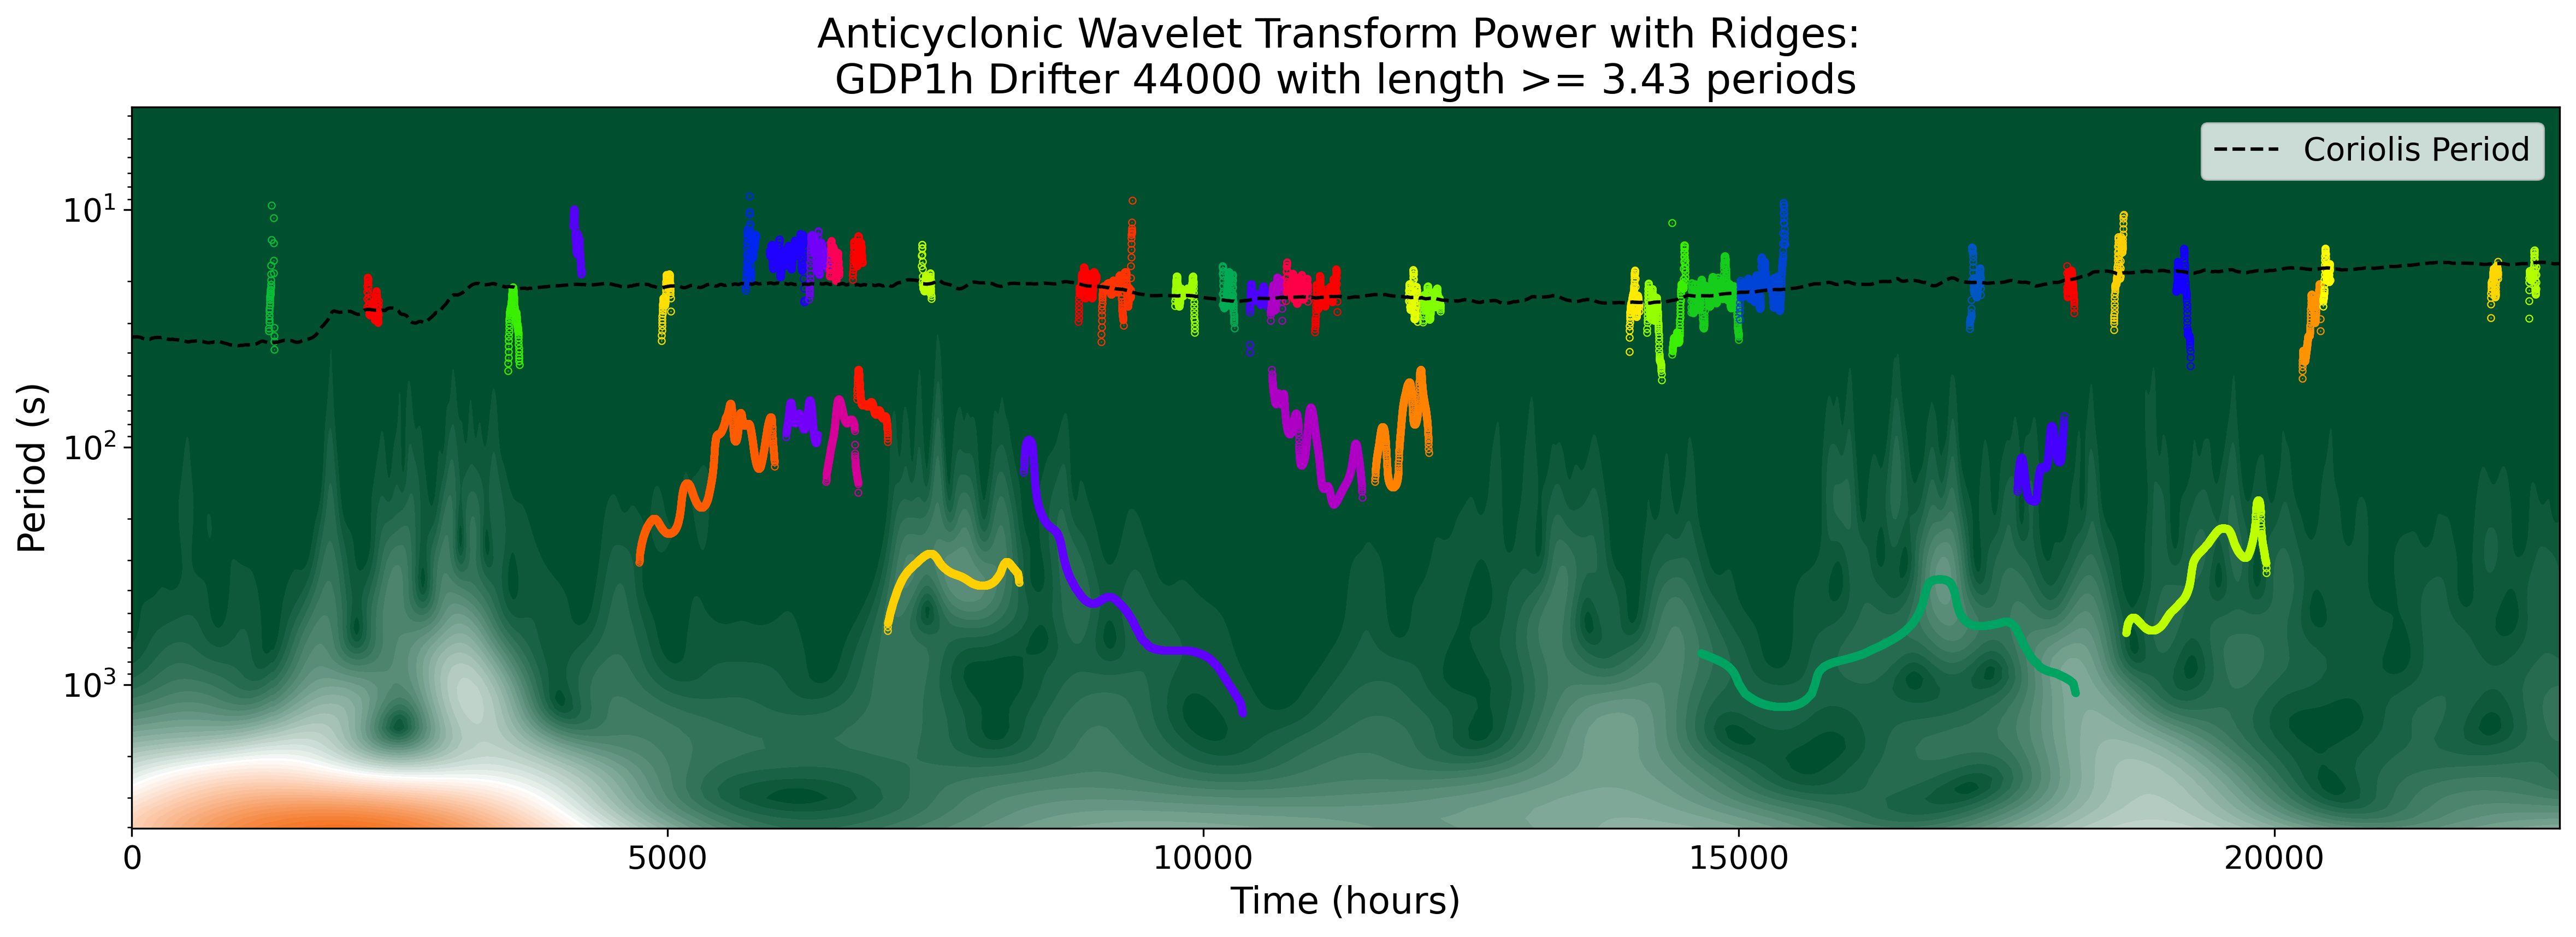

In [8]:
# Use the ridge analysis function to find ridges in the wavelet transform
ridges_plus = ridge_analysis(
    wavelet_plus,
    freqs=freqs,
    t=t,
    ridge_type="amplitude",
    amplitude_threshold=1.0,
    min_group_size=5,
    max_gap=2
)

ridges_minus = ridge_analysis(
    wavelet_minus,
    freqs=freqs,
    t=t,
    ridge_type="amplitude",
    amplitude_threshold=1.0,
    min_group_size=5,
    max_gap=2
)

# Extract ridge points and group data
ridge_points_plus = ridges_plus['ridge_points']
ridge_quantity_plus = ridges_plus['ridge_quantity']
num_groups_plus = ridges_plus['num_groups']
group_lengths_plus = ridges_plus['group_lengths']
group_data_plus = ridges_plus['group_data']
ridge_data_plus = ridges_plus['ridge_data']
inst_frequency_plus = ridges_plus['inst_frequency']

ridge_points_minus = ridges_minus['ridge_points']
ridge_quantity_minus = ridges_minus['ridge_quantity']
num_groups_minus = ridges_minus['num_groups']
group_lengths_minus = ridges_minus['group_lengths']
group_data_minus = ridges_minus['group_data']
ridge_data_minus = ridges_minus['ridge_data']
inst_frequency_minus = ridges_minus['inst_frequency']

# Filter out ridges with length less than the minimum length
min_length = 2.2 * (2.0 * np.sqrt(beta * gamma) / np.pi)
print(f"Minimum length for groups: {min_length:.2f} periods")

# Filter out groups with length less than min_length
filtered_group_ids_plus = [i+1 for i, length in enumerate(group_lengths_plus) if length >= min_length]
filtered_group_ids_minus = [i+1 for i, length in enumerate(group_lengths_minus) if length >= min_length]

# Print statistics
print(f"Plus transform groups: {num_groups_plus} total, {len(filtered_group_ids_plus)} filtered")
print(f"Minus transform groups: {num_groups_minus} total, {len(filtered_group_ids_minus)} filtered")

# Set larger font sizes for all plot text
plt.rcParams.update({
    'font.size': 16,          # Base font size (increased by 4)
    'axes.titlesize': 18,     # Title font size 
    'axes.labelsize': 16,     # Axis label font size
    'xtick.labelsize': 14,    # X-axis tick label font size
    'ytick.labelsize': 14,    # Y-axis tick label font size
    'legend.fontsize': 14,    # Legend font size
})

# Create a new figure with both wavelet transforms
plt.figure(figsize=(16, 6), dpi=300)
colors_plus = cm.prism(np.linspace(0, 1, num_groups_plus))

# Plot "plus" wavelet power as background
cax_plus = wavelet_contourf(
    plt.gca(), t, periods, power_plus, levels=100, cmap=discrete_orange_white_green
)

# Make ids for every group if filtered_group_ids_plus is empty
if len(filtered_group_ids_plus) == 0:
    print("No groups found after filtering, using all groups.")
    filtered_group_ids_plus = list(range(1, num_groups_plus + 1))

for group_id in filtered_group_ids_plus:
    
    # Use the new dictionary-based function
    freq_indices, time_indices, freq_values = get_group_data(
        group_data_plus, group_id, data_index=0
    )
    
    # Skip if empty
    if len(freq_indices) == 0:
        continue
    
    # Get color
    color_idx = (group_id - 1) % len(colors_plus)
    color = colors_plus[color_idx]
        
    # Calculate interpolated period values
    interp_period_values = 2.0 * np.pi / freq_values

    # Plot interpolated ridge points
    plt.scatter(t[time_indices], interp_period_values, 
                color=color, s=2.0, marker='.', linewidth=3.0)
    
# Plot coriolis period as a function of time
plt.plot(t, coriolis_period, color='black', linestyle='--', label='Coriolis Period')

# Set plot properties
plt.yscale('log')
plt.gca().invert_yaxis()
plt.title(f"Cyclonic Wavelet Transform Power with Ridges: \nGDP1h Drifter 44000 with length >= {min_length:.2f} periods")
plt.legend()
plt.xlabel("Time (hours)")
plt.ylabel("Period (s)")
# plt.colorbar(cax_plus, label='Wavelet Power')
plt.tight_layout()
plt.show()

# Create a new figure with both wavelet transforms
plt.figure(figsize=(16, 6), dpi=300)
colors_minus = cm.prism(np.linspace(0, 1, num_groups_minus))

# Plot "minus" wavelet power as background
cax_minus = wavelet_contourf(
    plt.gca(), t, periods, power_minus, levels=100, cmap=discrete_orange_white_green
)

# Make ids for every group if filtered_group_ids_minus is empty
if len(filtered_group_ids_minus) == 0:
    filtered_group_ids_minus = list(range(1, num_groups_minus + 1))

for group_id in filtered_group_ids_minus:
    # Use the new dictionary-based function
    freq_indices, time_indices, freq_values = get_group_data(
        group_data_minus, group_id, data_index=0
    )
    
    # Skip if empty
    if len(freq_indices) == 0:
        continue
    
    # Get color
    color_idx = (group_id - 1) % len(colors_minus)
    color = colors_minus[color_idx]
        
    # Calculate interpolated period values
    interp_period_values = 2.0 * np.pi / freq_values

    # Plot interpolated ridge points
    plt.scatter(t[time_indices], interp_period_values, 
                color=color, s=1.0, marker='.', linewidth=3.0)
    
# Plot coriolis period as a function of time
plt.plot(t, coriolis_period, color='black', linestyle='--', label='Coriolis Period')

# Set plot properties
plt.yscale('log')
plt.gca().invert_yaxis()
plt.title(f"Anticyclonic Wavelet Transform Power with Ridges: \nGDP1h Drifter 44000 with length >= {min_length:.2f} periods")
plt.legend()
plt.xlabel("Time (hours)")
plt.ylabel("Period (s)")    
# plt.colorbar(cax_minus, label='Wavelet Amplitude')
plt.tight_layout()
plt.show()

Ridge group 87 time range:
  Start: 2005-04-26 22:00:00
  End: 2005-08-10 06:00:00


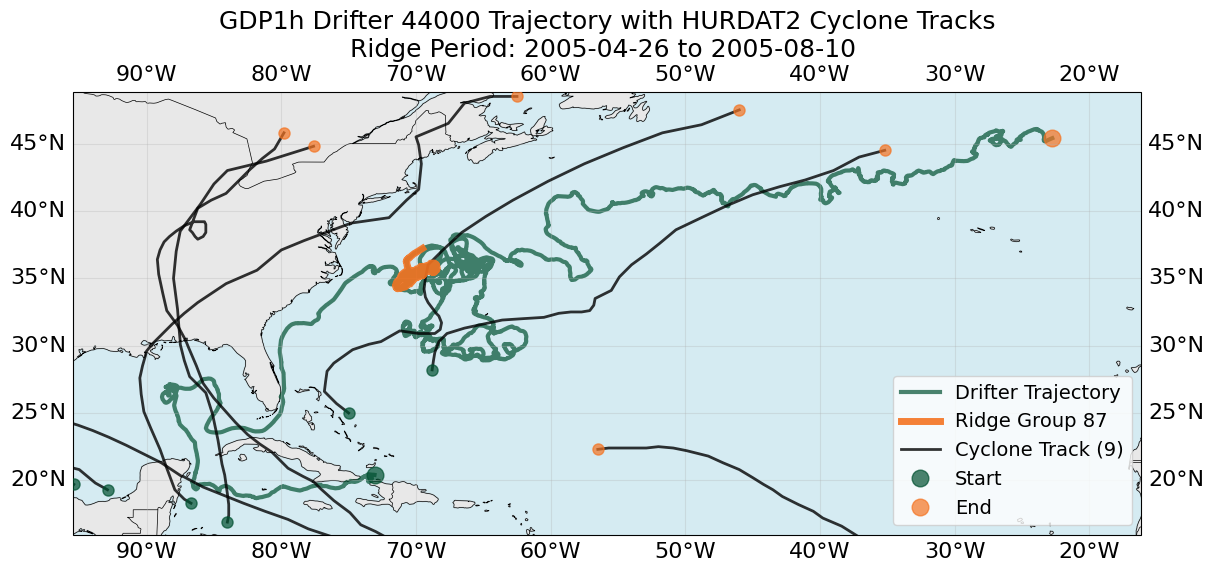

In [9]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from clouddrift.datasets import hurdat2

# Load the HURDAT2 dataset
hurdat2_ds = hurdat2(basin='atlantic')

# Get ridge group 87 time period first
target_group_id = 87
ridge_start_time = None
ridge_end_time = None

if target_group_id in filtered_group_ids_plus:
    freq_indices, time_indices, freq_values = get_group_data(
        group_data_plus, target_group_id, data_index=0
    )
    
    if len(time_indices) > 0:
        # Get the actual datetime range for ridge group 87
        ridge_start_time = ds.time[sli].values[time_indices[0]]
        ridge_end_time = ds.time[sli].values[time_indices[-1]]
        
        print(f"Ridge group {target_group_id} time range:")
        print(f"  Start: {pd.to_datetime(ridge_start_time)}")
        print(f"  End: {pd.to_datetime(ridge_end_time)}")
    else:
        print(f"Ridge group {target_group_id} has no data points")
else:
    print(f"Ridge group {target_group_id} not found in filtered groups")

# Only proceed if we have ridge timing data
if ridge_start_time is not None and ridge_end_time is not None:
    # Convert to numpy datetime64 for filtering storms
    start_date = ridge_start_time
    end_date = ridge_end_time
    
    storms = cd.ragged.subset(
        hurdat2_ds,
        {"time": (start_date, end_date)},
        row_dim_name="traj",
    )
    
    # Set larger font sizes for all plot text
    plt.rcParams.update({
        'font.size': 16,          # Base font size (increased by 4)
        'axes.titlesize': 18,     # Title font size 
        'axes.labelsize': 16,     # Axis label font size
        'xtick.labelsize': 14,    # X-axis tick label font size
        'ytick.labelsize': 14,    # Y-axis tick label font size
        'legend.fontsize': 14,    # Legend font size
    })
    
    # Create a map figure
    fig = plt.figure(figsize=(24, 6))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
    
    # Add map features
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.add_feature(cfeature.OCEAN, color='lightblue', alpha=0.5)
    ax.add_feature(cfeature.LAND, color='lightgray', alpha=0.5)
    
    # Plot the drifter trajectory
    ax.plot(lon, lat, color=green_end, linewidth=3, alpha=0.7, transform=ccrs.PlateCarree(), label='Drifter Trajectory')
    
    # Highlight the ridge group 87 segment
    ridge_lon = lon[time_indices]
    ridge_lat = lat[time_indices]
    ax.plot(ridge_lon, ridge_lat, color=orange_start, linewidth=5, alpha=0.9, 
            transform=ccrs.PlateCarree(), label=f'Ridge Group {target_group_id}', zorder=4)
    
    # Plot storm trajectories (only during ridge period)
    storm_count = 0
    if len(storms["rowsize"]) > 0:
        storm_traj_idx = cd.ragged.rowsize_to_index(storms["rowsize"])
        
        for i in range(len(storms["rowsize"])):
            storm_slice = slice(storm_traj_idx[i], storm_traj_idx[i+1])
            storm_lon = storms.lon[storm_slice].values
            storm_lat = storms.lat[storm_slice].values
            storm_times = storms.time[storm_slice].values
            
            # Plot storm trajectory
            ax.plot(storm_lon, storm_lat, color='black', linewidth=2, alpha=0.8, 
                    transform=ccrs.PlateCarree(), zorder=3)
            
            # Mark storm start and end points
            ax.plot(storm_lon[0], storm_lat[0], 'o', color=green_end, markersize=8, 
                    transform=ccrs.PlateCarree(), alpha=0.7, zorder=3)
            ax.plot(storm_lon[-1], storm_lat[-1], 'o', color=orange_start, markersize=8, 
                    transform=ccrs.PlateCarree(), alpha=0.7, zorder=3)
            
            storm_count += 1
    
    # Add legend entries
    if storm_count > 0:
        ax.plot([], [], color='black', linewidth=2, alpha=0.8, label=f'Cyclone Track ({storm_count})')
    
    # Mark drifter start and end points
    ax.plot(lon[0], lat[0], 'o', color=green_end, markersize=12, transform=ccrs.PlateCarree(), label='Start', alpha=0.7)
    ax.plot(lon[-1], lat[-1], 'o', color=orange_start, markersize=12, transform=ccrs.PlateCarree(), label='End', alpha=0.7)


    # Set extent to focus on the trajectory
    lon_margin = (lon.max() - lon.min()) * 0.1
    lat_margin = (lat.max() - lat.min()) * 0.1
    ax.set_extent([lon.min() - lon_margin, lon.max() + lon_margin, 
                    lat.min() - lat_margin, lat.max() + lat_margin], 
                    crs=ccrs.PlateCarree())
    
    # Add gridlines
    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.3)
    
    # Add legend and title
    ax.legend(loc='lower right')
    ax.set_title(f'GDP1h Drifter {n} Trajectory with HURDAT2 Cyclone Tracks\n'
                f'Ridge Period: {pd.to_datetime(start_date).strftime("%Y-%m-%d")} to {pd.to_datetime(end_date).strftime("%Y-%m-%d")} '
                )
    
    plt.tight_layout()
    plt.show()

else:
    print("Cannot create plot - ridge group 87 timing data not available")

In [10]:
# Get the start and end times for the drifter trajectory
start_time = ds.time[sli].values[0]
end_time = ds.time[sli].values[-1]

# Convert to readable datetime format
import pandas as pd
start_datetime = pd.to_datetime(start_time)
end_datetime = pd.to_datetime(end_time)

print(f"Drifter {n} trajectory:")
print(f"Start time: {start_datetime}")
print(f"End time: {end_datetime}")
print(f"Duration: {end_datetime - start_datetime}")

# You can also get the duration in days
duration_days = (end_time - start_time) / np.timedelta64(1, 'D')
print(f"Duration in days: {duration_days:.1f}")

Drifter 44000 trajectory:
Start time: 2004-10-13 03:00:00
End time: 2007-05-15 10:00:00
Duration: 944 days 07:00:00
Duration in days: 944.3


Ridge group 87 has 2529 points


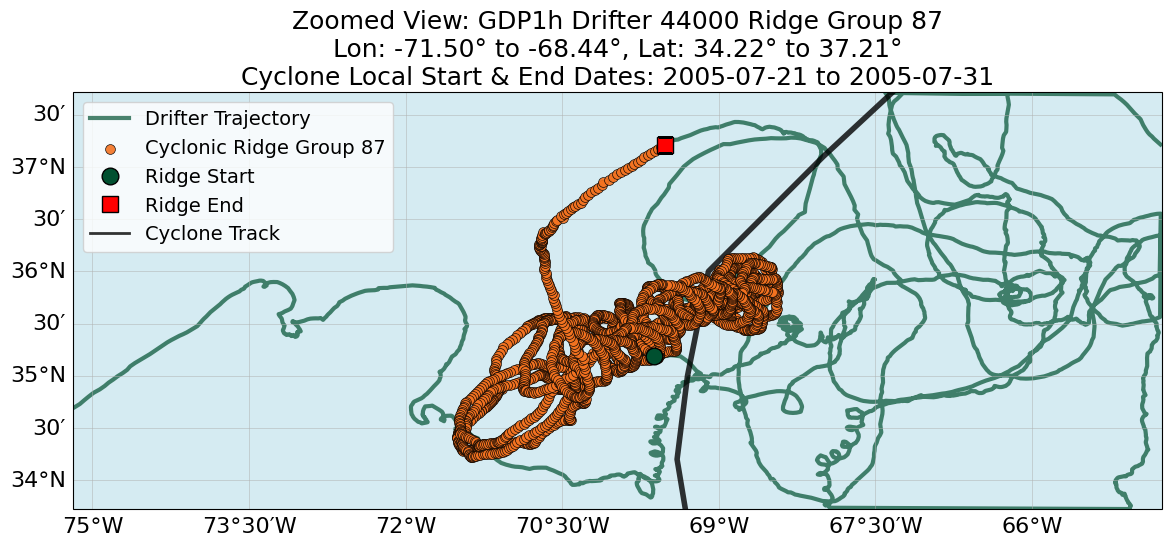

In [21]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from clouddrift.datasets import hurdat2

# Set larger font sizes for all plot text
plt.rcParams.update({
    'font.size': 16,          # Base font size (increased by 4)
    'axes.titlesize': 18,     # Title font size 
    'axes.labelsize': 16,     # Axis label font size
    'xtick.labelsize': 14,    # X-axis tick label font size
    'ytick.labelsize': 14,    # Y-axis tick label font size
    'legend.fontsize': 14,    # Legend font size
})

# Get ridge group 87 data first to determine zoom extent
target_group_id = 87
ridge_lon = None
ridge_lat = None
ridge_start_time = None
ridge_end_time = None

if target_group_id in filtered_group_ids_plus:
    freq_indices, time_indices, freq_values = get_group_data(
        group_data_plus, target_group_id, data_index=0
    )
    
    if len(time_indices) > 0:
        ridge_lon = lon[time_indices]
        ridge_lat = lat[time_indices]
        # Get the actual datetime range for ridge group 87
        ridge_start_time = ds.time[sli].values[time_indices[0]]
        ridge_end_time = ds.time[sli].values[time_indices[-1]]
        print(f"Ridge group {target_group_id} has {len(time_indices)} points")
    else:
        print(f"Ridge group {target_group_id} has no data points")
else:
    print(f"Ridge group {target_group_id} not found in filtered groups")
    print(f"Available cyclonic ridge groups: {filtered_group_ids_plus}")

# Only create the plot if we have ridge data
if ridge_lon is not None and ridge_lat is not None:
    # Load and filter cyclone data for the ridge period
    hurdat2_ds = hurdat2(basin='atlantic')
    storms = cd.ragged.subset(
        hurdat2_ds,
        {"time": (ridge_start_time, ridge_end_time)},
        row_dim_name="traj",
    )
    
    # Create a zoomed-in map figure
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

    # Add map features
    ax.add_feature(cfeature.COASTLINE, linewidth=1.0)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.add_feature(cfeature.OCEAN, color='lightblue', alpha=0.5)
    ax.add_feature(cfeature.LAND, color='lightgray', alpha=0.5)

    # Calculate extent based on ridge segment with some padding
    ridge_lon_min, ridge_lon_max = ridge_lon.min(), ridge_lon.max()
    ridge_lat_min, ridge_lat_max = ridge_lat.min(), ridge_lat.max()
    
    # Add padding around the ridge segment
    lon_padding = (ridge_lon_max - ridge_lon_min) * 1.2
    lat_padding = (ridge_lat_max - ridge_lat_min) * 0.1
    
    # Ensure minimum padding for very small segments
    lon_padding = max(lon_padding, 0.5)
    lat_padding = max(lat_padding, 0.5)

    zoom_extent = [ridge_lon_min - lon_padding, ridge_lon_max + lon_padding,
                   ridge_lat_min - lat_padding, ridge_lat_max + lat_padding]

    # Plot the trajectory segment in the zoomed region
    trajectory_mask = ((lon >= zoom_extent[0]) & (lon <= zoom_extent[1]) & 
                      (lat >= zoom_extent[2]) & (lat <= zoom_extent[3]))
    
    if trajectory_mask.any():
        ax.plot(lon[trajectory_mask], lat[trajectory_mask], 
                color=green_end, linewidth=3, alpha=0.7, 
                transform=ccrs.PlateCarree(), label='Drifter Trajectory')

    # Plot the ridge group with larger markers
    ax.scatter(ridge_lon, ridge_lat, c=orange_start, s=50, alpha=0.9, 
               transform=ccrs.PlateCarree(), label=f'Cyclonic Ridge Group {target_group_id}', 
               zorder=5, edgecolors='black', linewidth=0.5)

    # Mark first and last points of the ridge segment
    ax.plot(ridge_lon[0], ridge_lat[0], 'o', color=green_end, markersize=12, 
            transform=ccrs.PlateCarree(), label='Ridge Start', zorder=6, 
            markeredgecolor='black', markeredgewidth=1)
    ax.plot(ridge_lon[-1], ridge_lat[-1], 's', color='red', markersize=12, 
            transform=ccrs.PlateCarree(), label='Ridge End', zorder=6,
            markeredgecolor='black', markeredgewidth=1)

    # Plot cyclone trajectories within the zoom extent
    storm_count = 0
    storm_start_time = []
    storm_end_time = []
    if len(storms["rowsize"]) > 0:
        storm_traj_idx = cd.ragged.rowsize_to_index(storms["rowsize"])
        
        for i in range(len(storms["rowsize"])):
            storm_slice = slice(storm_traj_idx[i], storm_traj_idx[i+1])
            storm_lon = storms.lon[storm_slice].values
            storm_lat = storms.lat[storm_slice].values
            
            # Check if storm passes through the zoom region
            storm_in_region = ((storm_lon >= zoom_extent[0]) & (storm_lon <= zoom_extent[1]) & 
                              (storm_lat >= zoom_extent[2]) & (storm_lat <= zoom_extent[3]))
            
            if storm_in_region.any():
                # Plot storm trajectory
                ax.plot(storm_lon, storm_lat, color='black', linewidth=4, alpha=0.8, 
                        transform=ccrs.PlateCarree(), zorder=3)
                
                # Mark storm start and end points
                ax.plot(storm_lon[0], storm_lat[0], 'o', color='red', markersize=8, 
                        transform=ccrs.PlateCarree(), alpha=0.8, zorder=3)
                ax.plot(storm_lon[-1], storm_lat[-1], 's', color='darkred', markersize=8, 
                        transform=ccrs.PlateCarree(), alpha=0.8, zorder=3)
                
                storm_start_time.append(storms.time[storm_slice].values[0])
                storm_end_time.append(storms.time[storm_slice].values[-1])

                storm_count += 1

    # Set the zoomed extent
    ax.set_extent(zoom_extent, crs=ccrs.PlateCarree())

    # Add cyclone legend entry if storms are present
    if storm_count > 0:
        ax.plot([], [], color='black', linewidth=2, alpha=0.8, label=f'Cyclone Track')

    # Add detailed gridlines
    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,
                      linewidth=0.5, alpha=0.7)
    gl.top_labels = False
    gl.right_labels = False

    # Add legend and title
    ax.legend(loc='upper left')
    
    # Update title to include cyclone information
    title = f'Zoomed View: GDP1h Drifter {n} Ridge Group {target_group_id}\n'
    title += f'Lon: {ridge_lon_min:.2f}° to {ridge_lon_max:.2f}°, '
    title += f'Lat: {ridge_lat_min:.2f}° to {ridge_lat_max:.2f}°'
    title += (
        f'\nCyclone Local Start & End Dates: '
        f'{pd.to_datetime(storm_start_time[0]).date()} to '
        f'{pd.to_datetime(storm_end_time[-1]).date()}'
    )
    
    ax.set_title(title)

    plt.tight_layout()
    plt.show()
else:
    print("Cannot create zoomed plot - no ridge data available")